# **IMPORTACIÓN DATASET Y LIBRERÍAS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score, precision_score, recall_score, f1_score
from sklearn.tree import export_text, plot_tree
from sklearn.svm import SVC
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
url = "https://drive.google.com/uc?export=download&id=1BYBESNTPvsL3GF0YlN7TAQLjTkU7MdMu"
df = pd.read_excel(url)
df


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


**Tratamos los datos con errores de transcripicón o atípicos.**

In [ ]:
# Eliminar registros donde px_height o sc_w son igual a 0
df = df[(df['px_height'] > 0) & (df['px_width'] > 0) & (df['sc_h'] > 0) & (df['sc_w'] > 0)]

# Verificar cuántas filas quedan después de la limpieza
remaining_rows = df.shape[0]
print(f"Número de filas restantes después de la limpieza: {remaining_rows}")


Número de filas restantes después de la limpieza: 1819


In [ ]:
X = df.drop('price_range', axis=1)
y = df['price_range']


**Dividimos en datos de Train y test, y hacemos un escalado de las variables que no sean binarias en base a train.**



In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  # 75% train, 25% test

# Identificar columnas no binarias (aquellas con más de 2 valores únicos)
non_binary_columns = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Crear y ajustar el escalador con el conjunto de entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = X_train.copy()
X_train_scaled[non_binary_columns] = scaler.fit_transform(X_train[non_binary_columns])

# Transformar el conjunto de prueba utilizando el mismo escalador ajustado
X_test_scaled = X_test.copy()
X_test_scaled[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

# Guardar los datos originales sin escalado para referencia
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

# Verificación
print("Conjunto de entrenamiento escalado (primeras filas):")
print(X_train_scaled.head())



Conjunto de entrenamiento escalado (primeras filas):
      battery_power  blue  clock_speed  dual_sim        fc  four_g  \
1662       0.835003     0          0.8         0  0.055556       0   
1025       0.387442     1          0.8         1  0.722222       0   
1995       0.195725     1          0.0         1  0.000000       1   
450        0.140949     1          0.0         1  0.166667       1   
1542       0.939880     0          0.0         0  0.500000       1   

      int_memory     m_dep  mobile_wt   n_cores    pc  px_height  px_width  \
1662    0.032258  0.555556   0.550000  1.000000  0.45   0.764676  0.969292   
1025    0.758065  1.000000   0.158333  0.285714  0.85   0.144461  0.012684   
1995    0.000000  0.777778   0.216667  0.714286  0.70   0.623277  0.927904   
450     0.532258  0.111111   0.033333  0.142857  0.50   0.284329  0.472630   
1542    0.451613  1.000000   0.258333  0.142857  0.95   0.070955  0.364486   

           ram      sc_h      sc_w  talk_time  three_g  t

In [ ]:
# 4. Verificar tamaños de los datasets
print("Tamaños de los datasets:")
print(f"Train: {X_train_orig.shape}, Test: {X_test_orig.shape}")

Tamaños de los datasets:
Train: (1364, 20), Test: (455, 20)


# **REGRESIÓN LOGÍSTICA**

**DATOS ESCALADOS**

In [ ]:
# Usamos los datos escalados
X_train = X_train_scaled
X_test = X_test_scaled

# Valores de regularización a probar
C_values = [100, 1000, 10000, 15000,
            20000, 30000, 50000, 100000]

print("\nResults with scaling:")
best_C_scaled = None
best_score_logistic_reg = float('-inf')

for C in C_values:
    logistic_model = LogisticRegression(C=C, penalty='l2', max_iter=10000, random_state=42)
    scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')
    avg_score = scores.mean()
    print(f"C: {C}, Mean CV Accuracy: {avg_score:.4f}")
    if avg_score > best_score_logistic_reg:
        best_score_logistic_reg = avg_score
        best_C_scaled = C

print(f"\nBest C with scaling: {best_C_scaled}, Mean CV Accuracy: {best_score_logistic_reg:.4f}")

# Entrenar el modelo final con el mejor hiperparámetro
final_model_logistic_reg = LogisticRegression(C=best_C_scaled, penalty='l2', max_iter=1000, random_state=42)
final_model_logistic_reg.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_test = final_model_logistic_reg.predict(X_test)

# Matriz de confusión y reporte de clasificación
print("\n---------------- Test Confusion Matrix ----------------")
print(confusion_matrix(y_test, y_pred_test))

print("\n---------------- Classification Report ----------------")
print(classification_report(y_test, y_pred_test))

# Calcular métricas en entrenamiento y prueba
train_accuracy = accuracy_score(y_train, final_model_logistic_reg.predict(X_train))
train_precision = precision_score(y_train, final_model_logistic_reg.predict(X_train), average='macro')
train_recall = recall_score(y_train, final_model_logistic_reg.predict(X_train), average='macro')
train_f1 = f1_score(y_train, final_model_logistic_reg.predict(X_train), average='macro')

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')

# Imprimir métricas de entrenamiento y prueba
print("\nMetrics on Training Data:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision (Macro): {train_precision:.4f}")
print(f"Train Recall (Macro): {train_recall:.4f}")
print(f"Train F1 (Macro): {train_f1:.4f}")

print("\nMetrics on Test Data:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test F1 (Macro): {test_f1:.4f}")

# ERROR de entrenamiento y prueba
y_pred_train = final_model_logistic_reg.predict(X_train)
train_error = np.mean(y_pred_train != y_train)  # Método directo
test_error_rl = np.mean(y_pred_test != y_test)
print(f"\nTrain Error (directo): {train_error:.4f}")
print(f'Error de prueba Regresión Logística: {test_error_rl}, con parámetro = {best_C_scaled}')



Results with scaling:
C: 100, Mean CV Accuracy: 0.9612
C: 1000, Mean CV Accuracy: 0.9626
C: 10000, Mean CV Accuracy: 0.9648
C: 15000, Mean CV Accuracy: 0.9633
C: 20000, Mean CV Accuracy: 0.9655
C: 30000, Mean CV Accuracy: 0.9663
C: 50000, Mean CV Accuracy: 0.9648
C: 100000, Mean CV Accuracy: 0.9597

Best C with scaling: 30000, Mean CV Accuracy: 0.9663

---------------- Test Confusion Matrix ----------------
[[106   1   0   0]
 [  1 114   0   0]
 [  0   2 114   3]
 [  0   0   2 112]]

---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.97      0.99      0.98       115
           2       0.98      0.96      0.97       119
           3       0.97      0.98      0.98       114

    accuracy                           0.98       455
   macro avg       0.98      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455


Metrics on Trainin

# **ÁRBOLES DE DECISIÓN**

In [ ]:
# Usamos los datos sin escalar
X_train = X_train_orig
X_test = X_test_orig

# Definir los hiperparámetros para GridSearch
param_grid = {
    'min_samples_leaf': [1, 3, 5, 10],
    'min_samples_split': [2, 5, 10, 15],
    'max_depth': [3, 5, 10, 15],
    'criterion': ['entropy', 'gini'],
    'ccp_alpha': [0, 0.001, 0.01],
}

# Crear y ajustar GridSearchCV
grid_search_arbol = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring='accuracy')
grid_search_arbol.fit(X_train, y_train)

# Obtener el mejor clasificador y sus resultados
print("Best estimator found by grid search:")
print(grid_search_arbol.best_estimator_)
model = grid_search_arbol.best_estimator_

# Métricas de validación cruzada
print(f"CV-Validation Accuracy: {grid_search_arbol.best_score_:.4f}")

# Predicciones en el conjunto de prueba y entrenamiento
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Matriz de confusión y reporte de clasificación para el conjunto de prueba
print("\n---------------- Test Confusion Matrix ----------------")
print(confusion_matrix(y_test, y_pred_test))

print("\n---------------- Classification Report ----------------")
print(classification_report(y_test, y_pred_test))

# Métricas en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')

# Métricas en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='macro')
train_recall = recall_score(y_train, y_pred_train, average='macro')
train_f1 = f1_score(y_train, y_pred_train, average='macro')

# Imprimir métricas
print("\nMetrics on Training Data:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision (Macro): {train_precision:.4f}")
print(f"Train Recall (Macro): {train_recall:.4f}")
print(f"Train F1 (Macro): {train_f1:.4f}")

print("\nMetrics on Test Data:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test F1 (Macro): {test_f1:.4f}")

# ERROR en entrenamiento y prueba
train_error = np.mean(y_pred_train != y_train)  # Error en entrenamiento
test_error_arbol = np.mean(y_pred_test != y_test)  # Error en prueba
print(f"\nTrain Error (directo): {train_error:.4f}")
print(f"Error de prueba Árbol de decisión: {test_error_arbol:.4f}, con parámetros: {grid_search_arbol.best_estimator_}")


Best estimator found by grid search:
DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=10,
                       min_samples_leaf=5, random_state=42)
CV-Validation Accuracy: 0.8585

---------------- Test Confusion Matrix ----------------
[[ 96  11   0   0]
 [ 10  97   8   0]
 [  0  11  89  19]
 [  0   0  10 104]]

---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       107
           1       0.82      0.84      0.83       115
           2       0.83      0.75      0.79       119
           3       0.85      0.91      0.88       114

    accuracy                           0.85       455
   macro avg       0.85      0.85      0.85       455
weighted avg       0.85      0.85      0.85       455


Metrics on Training Data:
Train Accuracy: 0.9597
Train Precision (Macro): 0.9596
Train Recall (Macro): 0.9596
Train F1 (Macro): 0.9596

Metrics on Test Data:
Test Accuracy: 0

**Visualizamos la estructura del árbol**

In [ ]:
feature_names = X_train.columns.tolist()

# Visualize and interpret the tree structure
texto_modelo = export_text(
    decision_tree=model,
    feature_names=feature_names
)
print("\nDecision Tree Structure:\n")
print(texto_modelo)


Decision Tree Structure:

|--- ram <= 2217.50
|   |--- ram <= 1123.50
|   |   |--- px_height <= 1056.00
|   |   |   |--- battery_power <= 1838.00
|   |   |   |   |--- ram <= 1082.50
|   |   |   |   |   |--- px_width <= 1893.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- px_width >  1893.50
|   |   |   |   |   |   |--- px_height <= 470.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- px_height >  470.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- ram >  1082.50
|   |   |   |   |   |--- battery_power <= 1000.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- battery_power >  1000.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- battery_power >  1838.00
|   |   |   |   |--- ram <= 771.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ram >  771.50
|   |   |   |   |   |--- px_height <= 532.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- px_height >  532.50
|   |   |   |   |   |

Mostramos un gráfico algo más visual de la estructura.

Profundidad del árbol: 9
Número de nodos terminales: 79


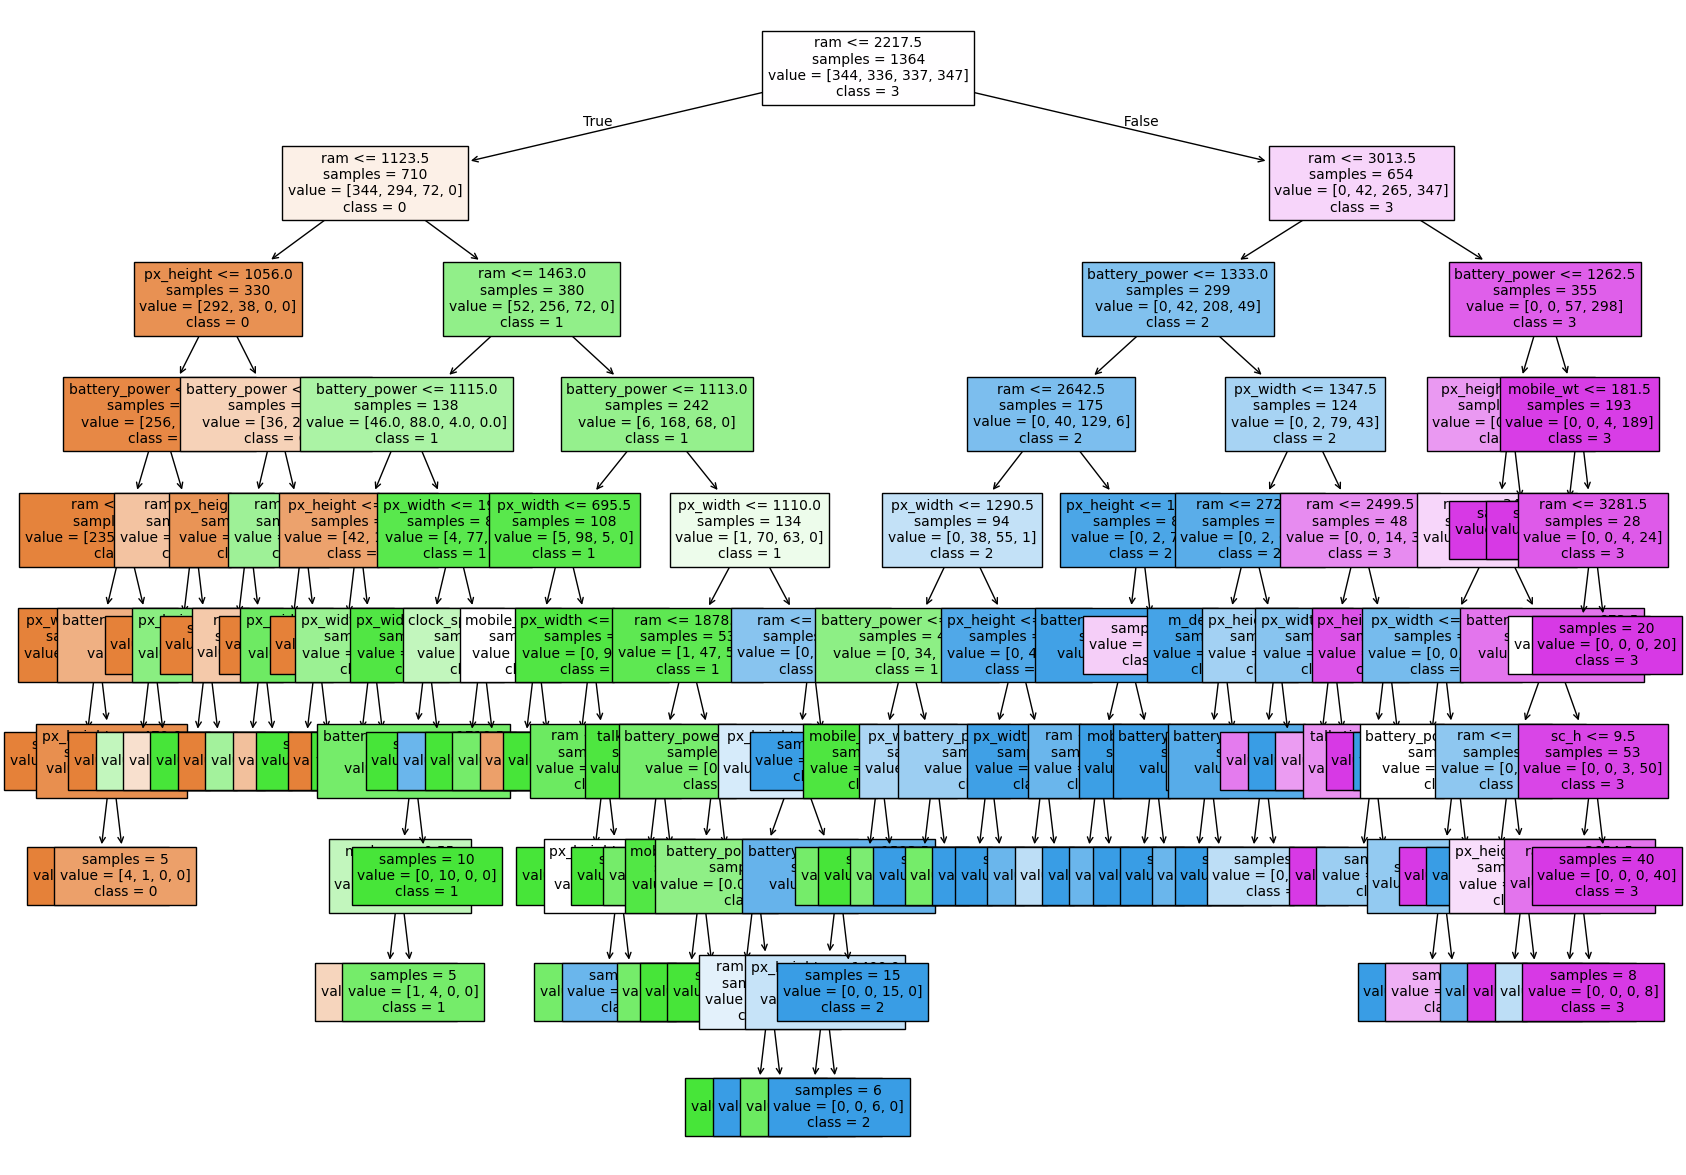

In [ ]:
class_names = list(set(y_train))

# Visualización del árbol
fig, ax = plt.subplots(figsize=(20, 15))

print(f"Profundidad del árbol: {model.get_depth()}")
print(f"Número de nodos terminales: {model.get_n_leaves()}")

plot = plot_tree(
    decision_tree=model,
    feature_names=feature_names,   # Nombres de las características dinámicos
    class_names=[str(cls) for cls in class_names],  # Clases dinámicas
    filled=True,
    impurity=False,
    fontsize=10,
    precision=2,
    ax=ax
)

plt.show()

# **K-NN**

In [ ]:
# Usamos los datos sin escalar
X_train = X_train_orig
X_test = X_test_orig

# Rango de valores para k y métricas de distancia
k_range = list(range(1, 21))
metrics = ['euclidean', 'manhattan', 'chebyshev']
param_grid = {'n_neighbors': k_range, 'metric': metrics}

# Inicializar el modelo KNN
knn = KNeighborsClassifier()

# Definir GridSearch para encontrar el mejor valor de k y métrica de distancia
grid_search_knn = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Resultados de la validación cruzada
print("CV-Validation Accuracy:", grid_search_knn.best_score_)

# Obtener los mejores hiperparámetros y ajustar el modelo
best_params = grid_search_knn.best_params_
k = best_params['n_neighbors']
metric = best_params['metric']
print(f"Mejor K: {k}, Mejor Métrica: {metric}")

knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
knn.fit(X_train, y_train)

# Predicción en el conjunto de prueba y entrenamiento
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

# Matriz de confusión y reporte de clasificación para el conjunto de prueba
print("\n---------------- Test Confusion Matrix ----------------")
print(confusion_matrix(y_test, y_pred_test))

print("\n---------------- Classification Report ----------------")
print(classification_report(y_test, y_pred_test))

# Métricas en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')

# Métricas en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='macro')
train_recall = recall_score(y_train, y_pred_train, average='macro')
train_f1 = f1_score(y_train, y_pred_train, average='macro')

# Imprimir métricas
print("\nMetrics on Training Data:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision (Macro): {train_precision:.4f}")
print(f"Train Recall (Macro): {train_recall:.4f}")
print(f"Train F1 (Macro): {train_f1:.4f}")

print("\nMetrics on Test Data:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test F1 (Macro): {test_f1:.4f}")

# ERROR en entrenamiento y prueba
train_error = np.mean(y_pred_train != y_train)  # Error en entrenamiento
test_error_knn = np.mean(y_pred_test != y_test)  # Error en prueba
print(f"\nTrain Error (directo): {train_error:.4f}")
print(f'\nError de prueba KNN: {test_error_knn:.4f}, con K = {k} y Métrica = {metric}')


CV-Validation Accuracy: 0.9361957921854872
Mejor K: 9, Mejor Métrica: euclidean

---------------- Test Confusion Matrix ----------------
[[104   3   0   0]
 [  3 103   9   0]
 [  0   5 105   9]
 [  0   0   7 107]]

---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       107
           1       0.93      0.90      0.91       115
           2       0.87      0.88      0.88       119
           3       0.92      0.94      0.93       114

    accuracy                           0.92       455
   macro avg       0.92      0.92      0.92       455
weighted avg       0.92      0.92      0.92       455


Metrics on Training Data:
Train Accuracy: 0.9494
Train Precision (Macro): 0.9492
Train Recall (Macro): 0.9492
Train F1 (Macro): 0.9492

Metrics on Test Data:
Test Accuracy: 0.9209
Test Precision (Macro): 0.9225
Test Recall (Macro): 0.9221
Test F1 (Macro): 0.9222

Train Error (directo): 0.0506

# **SVMs**

**CON ESCALADO**

In [ ]:
# Uso datos escalados
X_train = X_train_scaled
X_test = X_test_scaled

# Definir el rango ampliado de hiperparámetros a probar
param_grid = {
    'C': [100, 1000, 10000,
          50000,75000, 100000],
    'kernel': ['linear', 'poly', 'rbf'],
}

# Crear el modelo SVM
svm = SVC()

# Configurar GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor puntaje de validación cruzada
print("Best parameters found by grid search:", grid_search_svm.best_params_)
print('CV-Validation Accuracy:', grid_search_svm.best_score_)

# Entrenar el modelo con los mejores parámetros
best_svm = grid_search_svm.best_estimator_
best_svm.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_test = best_svm.predict(X_test)
y_pred_train = best_svm.predict(X_train)

# Matriz de confusión y reporte de clasificación
print("\n---------------- Test Confusion Matrix ----------------")
print(confusion_matrix(y_test, y_pred_test))

print("\n---------------- Classification Report ----------------")
print(classification_report(y_test, y_pred_test))

# Métricas en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')

# Métricas en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='macro')
train_recall = recall_score(y_train, y_pred_train, average='macro')
train_f1 = f1_score(y_train, y_pred_train, average='macro')

# Imprimir métricas
print("\nMetrics on Training Data:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision (Macro): {train_precision:.4f}")
print(f"Train Recall (Macro): {train_recall:.4f}")
print(f"Train F1 (Macro): {train_f1:.4f}")

print("\nMetrics on Test Data:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test F1 (Macro): {test_f1:.4f}")

# ERROR en entrenamiento y prueba
train_error = np.mean(y_pred_train != y_train)  # Error en entrenamiento
test_error_svm = np.mean(y_pred_test != y_test)  # Error en prueba
print(f"\nTrain Error (directo): {train_error:.4f}")
print(f'\nError de prueba SVM: {test_error_svm:.4f}, con parámetros: {best_svm}')


Best parameters found by grid search: {'C': 50000, 'kernel': 'linear'}
CV-Validation Accuracy: 0.9655324173465006

---------------- Test Confusion Matrix ----------------
[[105   2   0   0]
 [  1 114   0   0]
 [  0   2 111   6]
 [  0   0   1 113]]

---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       107
           1       0.97      0.99      0.98       115
           2       0.99      0.93      0.96       119
           3       0.95      0.99      0.97       114

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455


Metrics on Training Data:
Train Accuracy: 0.9978
Train Precision (Macro): 0.9978
Train Recall (Macro): 0.9978
Train F1 (Macro): 0.9978

Metrics on Test Data:
Test Accuracy: 0.9736
Test Precision (Macro): 0.9743
Test Recall (Macro): 0.9742
Test F1 (Macro): 0.9

# **ÁNALISIS MEJOR MODELO**

**Analizamos el mejor modelo en base al Mean CV Accuracy.**

In [ ]:
print("\nComparación de modelos según Mean CV Accuracy:")
print(f"Mean CV Accuracy de Regresión Logística: {best_score_logistic_reg:.4f}, con parámetro C = {best_C_scaled}")
print(f"Mean CV Accuracy de Árbol de Decisión: {grid_search_arbol.best_score_:.4f}, con parámetros: {grid_search_arbol.best_estimator_}")
print(f"Mean CV Accuracy de KNN: {grid_search_knn.best_score_:.4f}, con K = {k}")
print(f"Mean CV Accuracy de SVM: {grid_search_svm.best_score_:.4f}, con parámetros: {best_svm}")



Comparación de modelos según Mean CV Accuracy:
Mean CV Accuracy de Regresión Logística: 0.9663, con parámetro C = 30000
Mean CV Accuracy de Árbol de Decisión: 0.8585, con parámetros: DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=10,
                       min_samples_leaf=5, random_state=42)
Mean CV Accuracy de KNN: 0.9362, con K = 9
Mean CV Accuracy de SVM: 0.9655, con parámetros: SVC(C=50000, kernel='linear')


**Elegimos como mejor modelo el de Regresión logística con C = 30000.**

**Como no deberíamos tener los datos de test en un escenario realista, estos datos los escalamos al final simulando el escenario en el que un agente externo tiene estos datos y recibe solo el scaler y el modelo generado de nuestra parte.**

In [ ]:
# Transformar el conjunto de prueba utilizando el mismo escalador ajustado
X_test_scaled_ = X_test_orig.copy()
X_test_scaled_[non_binary_columns] = scaler.transform(X_test[non_binary_columns])

In [ ]:
# Entrenar el modelo final con el mejor hiperparámetro
final_model = final_model_logistic_reg

# Predicciones en el conjunto de prueba
y_pred_test = final_model.predict(X_test_scaled)

# Matriz de confusión y reporte de clasificación
print("\n---------------- Test Confusion Matrix ----------------")
print(confusion_matrix(y_test, y_pred_test))

print("\n---------------- Classification Report ----------------")
print(classification_report(y_test, y_pred_test))

# Calcular métricas en entrenamiento y prueba
train_accuracy = accuracy_score(y_train, final_model.predict(X_train))
train_precision = precision_score(y_train, final_model.predict(X_train), average='macro')
train_recall = recall_score(y_train, final_model.predict(X_train), average='macro')
train_f1 = f1_score(y_train, final_model.predict(X_train), average='macro')

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')


print("\nMetrics on Test Data:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (Macro): {test_precision:.4f}")
print(f"Test Recall (Macro): {test_recall:.4f}")
print(f"Test F1 (Macro): {test_f1:.4f}")

# ERROR de entrenamiento y prueba
test_error_rl = np.mean(y_pred_test != y_test)
print(f'Error de prueba Regresión Logística: {test_error_rl}, con parámetro = {best_C_scaled}')




---------------- Test Confusion Matrix ----------------
[[106   1   0   0]
 [  1 114   0   0]
 [  0   2 114   3]
 [  0   0   2 112]]

---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.97      0.99      0.98       115
           2       0.98      0.96      0.97       119
           3       0.97      0.98      0.98       114

    accuracy                           0.98       455
   macro avg       0.98      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455


Metrics on Test Data:
Test Accuracy: 0.9802
Test Precision (Macro): 0.9804
Test Recall (Macro): 0.9806
Test F1 (Macro): 0.9804
Error de prueba Regresión Logística: 0.01978021978021978, con parámetro = 30000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hacemos una representación gráfica de la natriz de correlación.

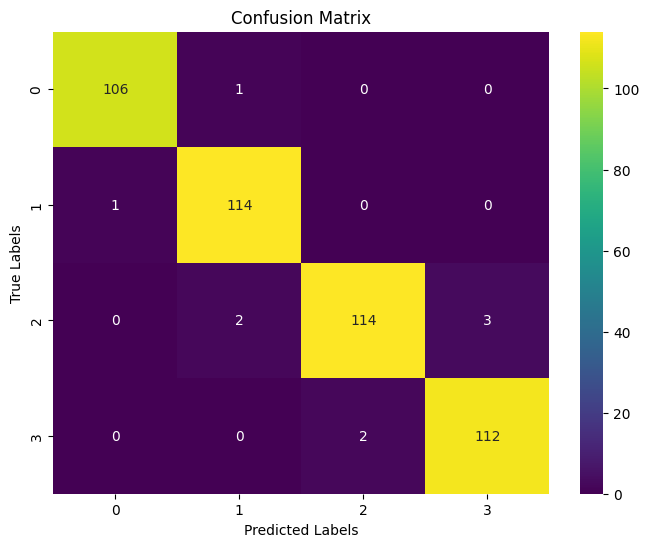

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
